<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load" data-toc-modified-id="Load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Classification" data-toc-modified-id="Classification-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Classification</a></span></li></ul></li></ul></div>

# Load

In [3]:
# coding: utf-8



import os
import numpy as np
import pandas as pd
import csv   
import cv2 as cv

from sklearn import preprocessing
from scipy.stats import gaussian_kde
from sklearn import metrics

import matplotlib.pylab as plt
import matplotlib.pyplot as mpplt
import matplotlib.image as mpimg
cmap = plt.cm.rainbow
import matplotlib
norm = matplotlib.colors.Normalize(vmin=0., vmax=1.)
from helpers import *

In [4]:
# # Load classification data


path_to_load_data = os.path.join('../data/')

X_modified = pd.read_csv(os.path.join(path_to_load_data,'spotData_withAnnotation.csv'), index_col=0)
X_others = pd.read_csv( os.path.join(path_to_load_data,'spotData_withAnnotation_others.csv'), index_col=0)

In [5]:
idx_spotWithSaturatedPixels = X_modified['numSaturatedPixels']>0
X_modified = X_modified[~idx_spotWithSaturatedPixels]
idx_spotWithSaturatedPixels = X_others['numSaturatedPixels']>0
X_others = X_others[~idx_spotWithSaturatedPixels]


print('X_modified',X_modified.shape)
print('X_others',X_others.shape)

X_modified (253, 19)
X_others (91, 19)


In [6]:
X_modified_lucas=X_modified.sort_values(['FOV_row', 'FOV_col'], ascending=[True, True])
X_others_lucas=X_others.sort_values(['FOV_row', 'FOV_col'], ascending=[True, True])


# # Classify using all data: X_modified and X_others

# ### Add features



X_modified["R/B"] = X_modified["R"] / X_modified["B"]
X_modified["G/B"] = X_modified["G"] / X_modified["B"]

X_others["R/B"] = X_others["R"] / X_others["B"]
X_others["G/B"] = X_others["G"] / X_others["B"]

print("X_modified: ",X_modified.shape)
print("X_others: ",X_others.shape)

X_modified:  (253, 21)
X_others:  (91, 21)


In [26]:
columns_X_modified = list(X_modified.columns)
columns_X_others = list(X_others.columns)
print("columns_X_modified: ",columns_X_modified)
print("columns_X_others: ",columns_X_others)


# ### Get features 



features = ['R','G','B','R_max','G_max','B_max', 'lap_total','numPixels','numSaturatedPixels', 'R/B', 'G/B','overlap'] 

X_modified_ = X_modified[features]
X_others_ = X_others[features]

print("X_modified_: ",X_modified_.shape)
print("X_others_: ",X_others_.shape)

X_ = np.concatenate( [X_modified_, X_others_], axis=0) #to keep others
#X_ = X_modified_ # to exclude others

X = np.concatenate( [X_modified, X_others], axis=0)
#X = X_modified # to exclude others


print("X_: ",X_.shape)
print("X: ",X.shape)


# ### Get labels



labels = ['Annotation'] 

# get labels
y_modified = X_modified[labels]
y_others = X_others[labels]
print("y_modified: ", y_modified.shape)
print('y_modified: ', np.unique(y_modified, return_counts=True))
print("y_others: ", y_others.shape)
print('y_others: ', np.unique(y_others, return_counts=True))



y = np.concatenate([y_modified,y_others]) #to keep others
#y = y_modified # to exclude others

y = np.asarray(y).flatten()
print('y: ', np.unique(y, return_counts=True))

# convert labels to 0 / 1
y[y=='Parasite'] = 1
y[y=='Platelet'] = 0
y[y=='Others'] = 2
print("y: ", y.shape)
print(np.unique(y, return_counts=True))


index_modified=np.array(X_modified.index)
index_others=np.array(X_others.index)
index_others=index_others+1000
index=np.concatenate([index_modified,index_others])

columns_X_modified:  ['FOV_row', 'FOV_col', 'x', 'y', 'r', 'R', 'G', 'B', 'R_max', 'G_max', 'B_max', 'lap_total', 'lap_max', 'numPixels', 'numSaturatedPixels', 'overlap', 'idx', 'URL', 'Annotation', 'R/B', 'G/B']
columns_X_others:  ['FOV_row', 'FOV_col', 'x', 'y', 'r', 'R', 'G', 'B', 'R_max', 'G_max', 'B_max', 'lap_total', 'lap_max', 'numPixels', 'numSaturatedPixels', 'overlap', 'idx', 'URL', 'Annotation', 'R/B', 'G/B']
X_modified_:  (253, 12)
X_others_:  (91, 12)
X_:  (344, 12)
X:  (344, 21)
y_modified:  (253, 1)
y_modified:  (array(['Parasite', 'Platelet'], dtype=object), array([182,  71]))
y_others:  (91, 1)
y_others:  (array(['Others'], dtype=object), array([91]))
y:  (array(['Others', 'Parasite', 'Platelet'], dtype=object), array([ 91, 182,  71]))
y:  (344,)
(array([0, 1, 2], dtype=object), array([ 71, 182,  91]))


## Classification

In [8]:
# # Classification on full dataset

from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from scipy import interp

In [9]:
kernel = 'linear'
class_names = np.asarray(['platelet', 'parasite', 'other'])


# convert y from object to numbers 
from sklearn.utils.multiclass import type_of_target
from sklearn.preprocessing import LabelEncoder
print("y before : ", type_of_target(y))
#print("y before : ", y)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print("y after: ", type_of_target(y))
#print("y after : ", y)

y before :  unknown
y after:  multiclass


In [10]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

#i = 0

#for train_index, test_index in skf.split(X_, y):
X_train_, X_test_ = X_, X_
y_train, y_test = y, y

X_train, X_test = X, X


print("============= NEW SPLIT =============")
print("X_train_: ",X_train_.shape)
print("X_test_: ",X_test_.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)
print("y_train: ", np.unique(y_train, return_counts=True))
print("y_test: ", np.unique(y_test, return_counts=True))

print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)

============= NEW SPLIT =============
X_train_:  (344, 12)
X_test_:  (344, 12)
y_train:  (344,)
y_test:  (344,)
y_train:  (array([0, 1, 2]), array([ 71, 182,  91]))
y_test:  (array([0, 1, 2]), array([ 71, 182,  91]))
X_train:  (344, 21)
X_test:  (344, 21)


In [11]:
# Normalize train data. 
mean = np.mean(X_train_, axis=0,keepdims=True)
std = np.std(X_train_, axis=0,keepdims=True)
X_train_ = (X_train_ - mean) / (std + 1e-8)
print("X_train_ after normalization: ",X_train_.shape)
# Normalize test data. Note: We use train mean+variance. Note: Do not normalize overlap! 
X_test_ = (X_test_ - mean) / (std + 1e-8)
print("X_test_ after normalization: ",X_test_.shape)

X_train_ after normalization:  (344, 12)
X_test_ after normalization:  (344, 12)


In [12]:
# Shuffle train data
p_train = np.random.permutation(len(y_train))
X_train_ = X_train_[p_train]
y_train = y_train[p_train]
X_train = X_train[p_train]

# Shuffle test data
p_test = np.random.permutation(len(y_test))
X_test_ = X_test_[p_test]
y_test = y_test[p_test]
X_test = X_test[p_test]
print('y_train',np.unique(y_train,return_counts=True))
print('y_test',np.unique(y_test,return_counts=True))

y_train (array([0, 1, 2]), array([ 71, 182,  91]))
y_test (array([0, 1, 2]), array([ 71, 182,  91]))


In [13]:
########################################
# TRAINING
########################################

# Create classifier
clf = svm.SVC(kernel=kernel, gamma=10, probability=True, random_state=10)
#clf = RandomForestClassifier(max_depth=50, n_estimators=100, max_features=1) 

# Train classifier to predict parasites vs rest of the world
y_train[y_train == 2] = 0
y_test[y_test == 2] = 0
print('y_train',np.unique(y_train,return_counts=True))
print('y_test',np.unique(y_test,return_counts=True))

# Train classifier
train_fit = clf.fit(X_train_, y_train)


#Deploy classifier on training set
dtrain_predprob = clf.predict_proba(X_train_)[:,1]
dtrain_pred = clf.predict(X_train_)

#Deploy classifier on test set
dtest_predprob = clf.predict_proba(X_test_)[:,1]
dtest_pred = clf.predict(X_test_)

y_train (array([0, 1]), array([162, 182]))
y_test (array([0, 1]), array([162, 182]))


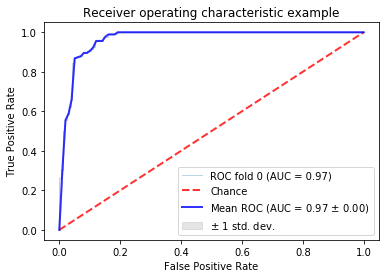

In [14]:
########################################
# PLOT RESULTS
########################################

i=0 

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, dtest_predprob)
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
plt.plot(fpr, tpr, lw=1, alpha=0.3,
         label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


    
    
    
    

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [32]:
X_modified

,FOV_row,FOV_col,x,y,r,R,G,B,R_max,G_max,...,lap_total,lap_max,numPixels,numSaturatedPixels,overlap,idx,URL,Annotation,R/B,G/B
0,11,9,31,1133,1.5,140.0,619.0,347.0,15.0,48.0,...,888.0,100.0,25,0,0.090416,335,https://octopi201910.s3-us-west-1.amazonaws.co...,Parasite,0.403458,1.783862
1,11,8,149,601,1.0,338.0,1162.0,639.0,42.0,110.0,...,1986.0,233.0,25,0,0.965872,178,https://octopi201910.s3-us-west-1.amazonaws.co...,Parasite,0.528951,1.818466
2,11,8,535,559,1.0,293.0,920.0,558.0,47.0,107.0,...,2100.0,353.0,25,0,1.000000,159,https://octopi201910.s3-us-west-1.amazonaws.co...,Parasite,0.525090,1.648746
3,11,7,582,999,1.0,281.0,918.0,506.0,42.0,98.0,...,1520.0,314.0,25,0,0.976540,336,https://octopi201910.s3-us-west-1.amazonaws.co...,Parasite,0.555336,1.814229
4,11,7,1358,925,1.0,332.0,671.0,483.0,57.0,93.0,...,1916.0,450.0,25,0,1.000000,313,https://octopi201910.s3-us-west-1.amazonaws.co...,Parasite,0.687371,1.389234
5,11,7,828,901,1.0,371.0,880.0,513.0,50.0,94.0,...,2140.0,236.0,25,0,1.000000,297,https://octopi201910.s3-us-west-1.amazonaws.co...,Parasite,0.723197,1.715400
6,11,7,858,134,1.0,373.0,1011.0,548.0,52.0,104.0,...,2246.0,301.0,25,0,1.000000,38,https://octopi201910.s3-us-west-1.amazonaws.co...,Parasite,0.680657,1.844891
7,11,4,259,266,1.0,58.0,411.0,397.0,8.0,38.0,...,678.0,76.0,25,0,0.321016,197,https://octopi201910.s3-us-west-1.amazonaws.co...,Platelet,0.146096,1.035264
8,11,3,335,970,1.0,81.0,1404.0,1221.0,10.0,114.0,...,1696.0,207.0,25,0,0.678862,1071,https://octopi201910.s3-us-west-1.amazonaws.co...,Platelet,0.066339,1.149877
9,11,3,157,941,1.5,147.0,2261.0,2213.0,15.0,143.0,...,2074.0,208.0,25,0,0.125730,1035,https://octopi201910.s3-us-west-1.amazonaws.co...,Platelet,0.066426,1.021690


In [33]:
index_mis

[0,
 1,
 3,
 9,
 59,
 66,
 86,
 129,
 145,
 146,
 148,
 207,
 229,
 234,
 237,
 1020,
 1027,
 1029,
 1050,
 1077,
 1078,
 1086,
 1090]

In [43]:
index_mis=[]
for i in range(dtrain_pred.shape[0]):
    if dtrain_pred[i]==1 and y_train[i]==0:
        index_mis.append(index[i])

In [44]:
X_mis=pd.DataFrame(columns=['FOV_row','FOV_col','x','y'])
for ii in index_mis:
    if ii>1000:
        X_mis.append(X_others.iloc[ii-1000,0:4])
    else:
        X_mis.append(X_modified.iloc[ii,0:4])

In [45]:
X_mis

,FOV_row,FOV_col,x,y


In [47]:
X_mis.append(X_others.iloc[0,0:4])

,FOV_row,FOV_col,x,y
1,11,3,607,1336


In [ ]:
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)

print("dtest_predprob: ",dtest_predprob.shape)
print("dtest_pred: ",dtest_pred.shape)




dtrain_predprob = np.reshape(dtrain_predprob, [-1,1])
dtrain_pred = np.reshape(dtrain_pred, [-1,1])
print("dtrain_predprob: ",dtrain_predprob.shape)
print("dtrain_pred: ",dtrain_pred.shape)

dtest_predprob = np.reshape(dtest_predprob, [-1,1])
dtest_pred = np.reshape(dtest_pred, [-1,1])
print("dtest_predprob: ",dtest_predprob.shape)
print("dtest_pred: ",dtest_pred.shape)




X_train = np.hstack((X_train,dtrain_predprob))
X_train = np.hstack((X_train,dtrain_pred))
print("X_train: ",X_train.shape)

X_test = np.hstack((X_test,dtest_predprob))
X_test = np.hstack((X_test,dtest_pred))
print("X_test: ",X_test.shape)

columns_X_modified.append("predprob")
columns_X_modified.append("pred")
columns_X_others.append("predprob")
columns_X_others.append("pred")


# ### Save X_train and X_dev to disk



import pandas as pd

# check that both are equal
print("columns_X_modified: ",columns_X_modified)
print("columns_X_others: ",columns_X_others)

print('----------------------------')
print(X_train.shape)
print(len(columns_X_others))
print('----------------------------')



# df_X_train = pd.DataFrame(data=X_train, columns=columns_X_modified)
# df_X_test = pd.DataFrame(data=X_test, columns=columns_X_modified)

df_X_train = pd.DataFrame(data=X_train, columns=columns_X_modified)
df_X_test = pd.DataFrame(data=X_test, columns=columns_X_modified)



df_X_train.head(55)




df_X_test.head(15)




df_X_train.to_csv('./X_train.csv', index=True)
df_X_test.to_csv('./X_test.csv', index=True)




df_X_train.shape